In [1]:
import pandas as pd
import pickle 
import glob
from tqdm import tqdm_notebook

In [2]:
target = 'jak2'
molecule_df = pickle.load(open('/groups/cherkasvgrp/Student_backup/mkpandey/My_Projects/DDSgroups/Enamine2M_moldf_w_dockscore_5tgt.pkl','rb'))  #pickle.load(open(f'/groups/cherkasvgrp/Student_backup/mkpandey/My_Projects/DDSgroups/Projects/dock_{target}/iteration_0/2M_mols_w_dockscores_{target}.pkl','rb'))
molecule_df = molecule_df[molecule_df[f'{target}_dockscores']!=0]
molecule_df.shape

(1751486, 7)

In [3]:
# all_mols_virthits_0 = pickle.load(open('/groups/cherkasvgrp/Student_backup/mkpandey/My_Projects/DDSgroups/Projects/2FinalDockVina_jak2_bald_advanced_molformer_False_True/iteration_29/allmols_virthits_0.pkl','rb'))
# all_mols_virthits_0

In [4]:
all_mols_virthits_files = glob.glob('/groups/cherkasvgrp/Student_backup/mkpandey/My_Projects/DDSgroups/Projects/3FinalDockVina_jak2_bald_advanced_molformer_False_True/iteration_1/allmols_virthits_*.pkl')
len(all_mols_virthits_files)
all_virutal_hits = []
for f in tqdm_notebook(all_mols_virthits_files):
    all_virutal_hits.extend(pickle.load(open(f,'rb'))[1])
len(all_virutal_hits)


/tmp/ipykernel_2198972/3999469485.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for f in tqdm_notebook(all_mols_virthits_files):


  0%|          | 0/51 [00:00<?, ?it/s]

27752

In [5]:
all_docked_mols = pickle.load(open('/groups/cherkasvgrp/Student_backup/mkpandey/My_Projects/DDSgroups/Projects/3FinalDockVina_jak2_bald_advanced_molformer_False_True/iteration_1/all_docked_mols.pkl','rb'))
# all_docked_mols

In [6]:
all_docked_mols.train.keys()

dict_keys(['mol_ids', 'dock_scores', 'cutoff', 'smiles'])

In [7]:
all_docked_mols.train.cutoff

-9.6

In [8]:
result = []
dock_thresh = all_docked_mols.train.cutoff
for key in all_docked_mols:
    mols_ids = all_docked_mols[key].mol_ids
    smiles = all_docked_mols[key].smiles
    dock_scores = all_docked_mols[key].dock_scores
    for m,s,d in tqdm_notebook(zip(mols_ids,smiles,dock_scores)):
        if d<dock_thresh:
            result.append((m,s,d))

/tmp/ipykernel_2198972/1995491259.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for m,s,d in tqdm_notebook(zip(mols_ids,smiles,dock_scores)):


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [9]:
from typing import List, Tuple

def sort_by_pred_proba(
    mol_list: List[Tuple[str, str, float]]
) -> List[Tuple[str, str, float]]:
    return sorted(mol_list, key=lambda x: x[2], reverse=True)

In [11]:
import sys
sys.path.append('/groups/cherkasvgrp/Student_backup/mkpandey/My_Projects/DDSgroups/VinaAL')
from gpuvina import get_vina_scores_mul_gpu#, QuickVina2GPU
from easydict import EasyDict
import yaml

with open('/groups/cherkasvgrp/Student_backup/mkpandey/My_Projects/DDSgroups/config/params.yml', 'r') as f:
    config = EasyDict(yaml.safe_load(f))

def get_topK_mols(all_docked_mols, all_virtual_hits, config, topK=1000, dock_tolerance = 0.1):
    '''dock tolerance : what % more molecules to dock beyond topK to get real topK'''
    dock_thresh = all_docked_mols.train.cutoff
    result = []
    for key in all_docked_mols:
        mols_ids = all_docked_mols[key].mol_ids
        smiles = all_docked_mols[key].smiles
        dock_scores = all_docked_mols[key].dock_scores
        for m,s,d in tqdm_notebook(zip(mols_ids,smiles,dock_scores)):
            if d<dock_thresh:
                result.append((m,s,d))
    top_virt_hits = sort_by_pred_proba(all_virtual_hits)[0:int(1+dock_tolerance)*(max(topK-len(result),0))]
    print(len(top_virt_hits))
    
    # dock top virt hits 
    dock_mol_ids = [mol[0] for mol in top_virt_hits]
    dock_smiles_list = [mol[1] for mol in top_virt_hits]
    dock_scores = get_vina_scores_mul_gpu(dock_smiles_list, None, config, num_gpus=config.model_hps.num_gpus, 
                                        output_dir=f"{config.global_params.project_path}/{config.global_params.project_name}/final_docking/",
                                        dockscore_gt=None)
    top_virt_result = [(m,s,d) for m,s,d in zip(dock_mol_ids,dock_smiles_list, dock_scores)]
    # Combine both and sort by docking score
    combined = result + top_virt_result
    combined_sorted = sorted(combined, key=lambda x: x[2])  # Lower score = better

    # Take top-K
    topK_mols = combined_sorted[:topK]

    # Convert to DataFrame
    df_topK = pd.DataFrame(topK_mols, columns=["mol_id", "smiles", "dock_score"])
    
    return df_topK
    
topkdf = get_topK_mols(all_docked_mols, all_virutal_hits,config, topK=2000)
topkdf.tail(100)

/tmp/ipykernel_2198972/2183067847.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for m,s,d in tqdm_notebook(zip(mols_ids,smiles,dock_scores)):


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

776
All jobs with the specified name prefix have completed.


,mol_id,smiles,dock_score
1900,m_275592____14114712____25318826____14134114,O=C(C1=CC=CC2=C1C=CN2)N1CC2CCC(C1)N2C(=O)C1=CN...,-8.8
1901,m_280530____18825876____18895954____18880046,O=S(=O)(C1=CC=C(N2CCC3(CC3)C2)C2=CN=CC=C12)N1C...,-8.8
1902,s_2230____7463156____7465568,NS(=O)(=O)C1=CC=C2CCCN(CC(=O)NC3=CC=CC=C3C(=O)...,-8.8
1903,s_22____8795730____25493672,CC1=NNC2=CC=CC(C(=O)N3CCCCC3C3=CC=CC=C3)=C12,-8.8
1904,s_11____25842454____26251830,CN1C(C2=CC=CC=C2)=NC2=C1CCN(C(=O)CC1=CNC3=CC=N...,-8.8
...,...,...,...
1995,m_274860____15234950____17184678____12655980,CC1=CC=C2C(O)=C(C(=O)NC3CCC(N4C=C(C5=CC=CC=C5O...,-7.5
1996,s_12____2535808____25388754____25384476,CC1=CC=C(CN2C(=O)NC(C3=C4C=CC=CC4=CC=C3C)C3=C2...,-7.3
1997,s_12____18801306____25387826____25389778,CCC1=CC=CC=C1N1C(=S)NC(C2=CN=C3NC=C(Br)C3=C2)C...,-7.3
1998,m_281630____21613318____21620652____20773002,COC1=C(C(NC2=CN3N=CC=C3N=C2)C2=NN=NN2C2=C(C)C=...,-6.8


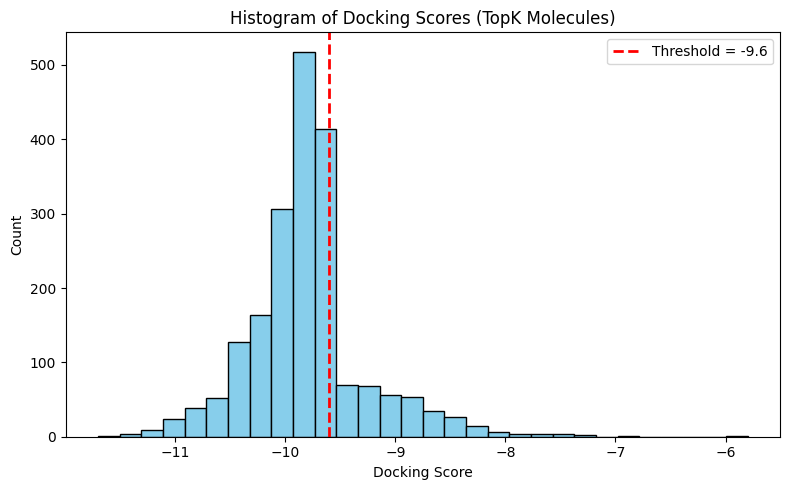

In [12]:
import matplotlib.pyplot as plt
threshold = -9.6
plt.figure(figsize=(8, 5))
plt.hist(topkdf['dock_score'], bins=30, color='skyblue', edgecolor='black')
plt.axvline(threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold = {threshold}')
plt.xlabel('Docking Score')
plt.ylabel('Count')
plt.title('Histogram of Docking Scores (TopK Molecules)')
plt.legend()
plt.tight_layout()
plt.show()

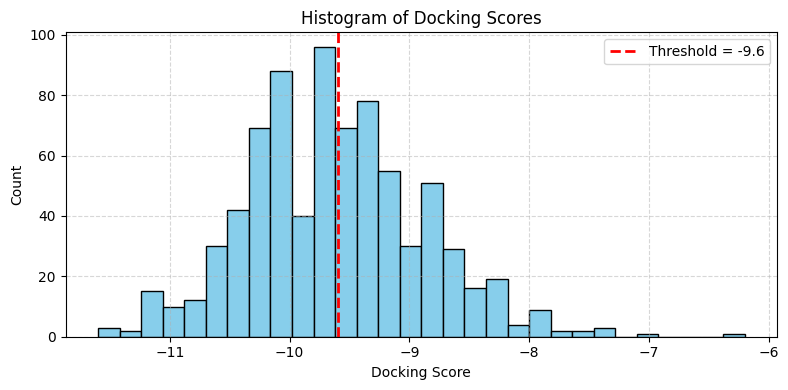

In [12]:
import matplotlib.pyplot as plt
dock_scores = [-9.9, -10.1, -10.2, -9.5, -10.1, -10.7, -10.1, -9.9, -9.9, -9.8, -10.7, -9.8, -10.2, -10.4, -8.2, -9.8, -8.8, -10.0, -8.7, -11.1, -10.2, -10.3, -10.0, -9.0, -8.9, -10.1, -9.4, -9.6, -10.0, -9.4, -7.3, -10.4, -11.3, -10.3, -9.8, -10.0, -10.1, -10.1, -9.4, -9.3, -9.3, -9.9, -8.8, -9.9, -10.6, -9.9, -8.9, -9.3, -8.8, -9.3, -9.4, -10.5, -9.8, -9.5, -9.6, -9.5, -8.1, -9.8, -8.8, -9.7, -9.4, -7.9, -9.8, -9.7, -9.7, -10.6, -9.3, -10.5, -10.0, -9.8, -9.3, -9.7, -10.7, -10.1, -8.9, -10.0, -9.7, -8.8, -10.5, -8.0, -10.4, -11.1, -9.2, -9.8, -10.3, -9.8, -9.7, -8.6, -9.6, -10.2, -8.3, -9.6, -8.9, -10.0, -10.2, -10.2, -10.2, -9.8, -9.7, -8.1, -9.0, -8.5, -9.1, -9.6, -8.9, -10.1, -9.4, -10.3, -9.6, -9.2, -9.8, -10.3, -10.2, -9.6, -10.3, -9.9, -9.1, -7.5, -9.1, -11.2, -8.0, -10.6, -11.1, -9.4, -10.2, -10.6, -8.6, -10.0, -10.0, -10.0, -9.0, -9.2, -9.5, -8.8, -9.4, -8.3, -11.1, -9.3, -8.6, -9.9, -10.2, -8.8, -9.3, -8.9, -11.2, -10.6, -10.0, -9.2, -10.7, -10.1, -8.6, -8.9, -9.1, -10.1, -9.7, -9.0, -9.7, -10.4, -10.2, -9.8, -9.3, -9.8, -8.7, -9.3, -9.7, -10.8, -9.5, -9.7, -9.6, -9.9, -9.7, -8.5, -10.1, -10.7, -10.1, -11.1, -9.0, -9.7, -10.3, -9.4, -9.7, -9.8, -9.7, -10.3, -10.1, -10.1, -10.3, -8.6, -9.6, -10.4, -10.0, -10.0, -7.7, -10.6, -9.5, -9.2, -10.4, -9.2, -9.8, -9.8, -10.0, -10.2, -9.6, -8.9, -9.0, -10.0, -8.8, -10.5, -10.0, -10.6, -10.0, -9.7, -10.0, -9.4, -9.9, -9.9, -10.0, -9.7, -9.9, -10.3, -11.0, -8.8, -9.7, -10.3, -8.7, -10.4, -10.3, -9.5, -8.9, -10.8, -9.4, -9.7, -10.2, -9.7, -8.8, -10.6, -9.8, -9.2, -10.1, -10.4, -10.1, -9.7, -9.5, -10.0, -10.5, -8.8, -8.0, -8.9, -9.3, -10.2, -9.3, -9.8, -10.4, -10.8, -9.5, -10.0, -11.5, -11.1, -9.0, -9.5, -9.6, -10.0, -10.1, -9.0, -11.2, -9.0, -9.1, -10.3, -10.4, -10.1, -10.4, -10.3, -10.1, -9.6, -10.1, -9.9, -9.7, -10.2, -10.5, -9.6, -10.5, -9.6, -10.4, -9.3, -9.9, -9.2, -9.2, -10.4, -9.0, -10.4, -9.8, -11.1, -8.7, -9.8, -10.3, -9.4, -9.1, -10.0, -9.4, -10.0, -9.6, -9.4, -10.9, -9.8, -10.5, -9.6, -9.8, -8.7, -11.1, -10.2, -9.7, -8.9, -9.4, -8.2, -10.9, -6.2, -11.6, -8.6, -8.2, -8.5, -10.0, -8.9, -10.2, -9.5, -9.3, -8.3, -9.9, -9.7, -10.3, -9.4, -9.5, -9.0, -9.3, -9.9, -8.8, -10.4, -9.2, -9.9, -9.5, -9.6, -9.3, -9.9, -9.6, -10.6, -9.1, -8.0, -9.7, -9.8, -10.7, -10.0, -10.7, -9.0, -10.0, -10.0, -10.4, -10.1, -10.8, -10.7, -9.2, -9.4, -10.3, -8.8, -9.7, -9.2, -8.9, -9.9, -8.6, -9.6, -9.1, -9.3, -9.0, -10.1, -9.8, -10.2, -10.0, -10.1, -9.7, -9.2, -9.2, -10.2, -9.5, -9.5, -9.1, -10.0, -8.9, -8.9, -9.0, -9.4, -10.6, -10.8, -9.6, -8.6, -9.6, -7.9, -9.8, -8.4, -9.9, -10.7, -8.8, -8.5, -9.6, -10.5, -10.1, -10.0, -10.2, -9.3, -9.7, -9.6, -9.2, -8.5, -9.4, -9.0, -9.6, -9.2, -9.5, -8.7, -9.6, -10.8, -9.9, -9.9, -9.2, -9.5, -9.8, -8.3, -8.4, -8.3, -8.9, -8.7, -9.8, -10.8, -10.6, -11.2, -8.8, -9.7, -9.4, -10.2, -10.3, -9.7, -10.5, -8.5, -8.7, -9.1, -7.9, -9.0, -10.1, -8.8, -9.1, -10.7, -10.0, -9.0, -9.2, -8.2, -8.8, -8.5, -9.8, -11.0, -9.3, -8.6, -9.4, -9.4, -10.3, -9.8, -9.8, -10.5, -8.9, -9.4, -8.9, -8.8, -9.7, -8.6, -11.2, -8.3, -9.7, -9.9, -9.9, -9.5, -10.4, -9.6, -8.9, -9.9, -9.2, -8.5, -9.6, -10.8, -10.4, -9.8, -9.2, -9.5, -9.1, -8.2, -10.1, -9.3, -10.4, -9.6, -9.0, -9.2, -10.2, -9.9, -9.5, -9.2, -10.4, -10.3, -9.8, -9.8, -7.9, -10.2, -9.5, -8.7, -10.2, -9.7, -10.5, -10.8, -9.3, -10.1, -10.2, -10.2, -9.7, -9.8, -9.3, -9.4, -8.1, -10.9, -8.9, -10.3, -10.0, -8.2, -8.9, -9.9, -9.2, -8.3, -10.1, -8.9, -10.4, -9.5, -9.7, -10.6, -8.5, -9.4, -7.4, -9.9, -10.6, -9.5, -10.2, -9.8, -9.3, -9.9, -10.2, -9.3, -9.1, -10.0, -9.8, -9.7, -9.1, -9.4, -10.0, -10.4, -9.1, -10.4, -9.4, -9.8, -9.6, -10.2, -9.8, -9.9, -9.4, -9.9, -9.4, -9.4, -10.3, -10.4, -9.4, -9.9, -9.5, -9.5, -10.8, -10.2, -9.5, -10.0, -10.0, -9.4, -9.4, -9.1, -9.6, -10.4, -10.6, -9.7, -9.3, -10.7, -9.0, -9.2, -9.9, -10.8, -9.8, -7.3, -8.6, -10.5, -10.3, -10.2, -9.0, -8.2, -8.5, -10.4, -9.6, -10.2, -8.6, -8.3, -9.0, -9.4, -9.3, -9.8, -7.6, -9.8, -10.1, -10.3, -10.1, -9.3, -9.7, -11.4, -9.5, -9.2, -9.3, -9.3, -9.3, -9.2, -10.2, -10.6, -10.6, -8.2, -10.3, -9.8, -10.1, -8.9, -10.2, -8.7, -9.5, -10.8, -9.9, -7.7, -9.9, -9.4, -10.1, -9.1, -8.8, -9.0, -9.3, -9.5, -10.1, -9.4, -9.8, -8.8, -8.9, -10.3, -9.7, -9.1, -8.9, -10.2, -10.0, -10.9, -9.0, -8.8, -10.0, -10.4, -9.1, -10.1, -10.1, -8.7, -9.1, -9.0, -11.2, -9.8, -9.5, -10.6, -9.4, -10.6, -9.8, -9.9, -10.5, -8.9, -8.6, -9.3, -10.1, -10.0, -8.5, -10.2, -10.5, -9.1, -10.0, -9.1, -8.9, -8.7, -9.3, -9.0, -10.1, -7.1, -9.3, -8.4, -10.9, -9.1, -9.0, -8.2, -10.9, -9.5, -9.0, -8.6, -8.8, -9.2, -9.2, -9.2, -9.4, -10.3, -9.4, -10.0, -10.0, -9.3, -9.3, -9.5, -10.0, -9.7, -8.5, -10.1, -10.0, -9.4, -9.5, -9.0, -10.2, -9.9, -9.7, -10.3, -8.6, -11.1, -9.6, -9.1, -9.0, -9.9, -10.7, -11.0, -9.3, -11.5, -7.9, -9.5, -9.3, -10.1, -9.8, -8.7, -9.6, -10.9, -9.8, -8.2, -9.1, -9.6, -8.9, -8.6, -10.2, -9.7, -10.0, -9.7, -9.9, -8.2, -8.9, -10.2, -9.7, -10.3, -8.1, -9.7, -9.9, -10.0, -9.0, -10.2, -10.0, -9.7, -9.6, -9.7, -8.4, -9.7, -9.2, -10.0]

def plot_docking_scores(scores, threshold=-9.6):
    plt.figure(figsize=(8, 4))
    plt.plot(scores, marker='o', linestyle='-', label='Docking Score')
    plt.axhline(y=threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
    plt.xlabel('Molecule Index')
    plt.ylabel('Docking Score')
    plt.title('Docking Scores with Threshold')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
def plot_docking_scores(scores, threshold=-9.6):
    plt.figure(figsize=(8, 4))
    plt.hist(scores, bins=30, color='skyblue', edgecolor='black')
    plt.axvline(x=threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold = {threshold}')
    plt.xlabel('Docking Score')
    plt.ylabel('Count')
    plt.title('Histogram of Docking Scores')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()
plot_docking_scores(dock_scores)


In [13]:
sum(score <= -9.6 for score in dock_scores), len(dock_scores)

(442, 776)

In [14]:
442/776

0.5695876288659794